In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import os
from habnet.featuriser.featurise import Featuriser, MOL_TYPES
from habnet.featuriser.habnet_featurizer import AtomHAbNetFeaturizer
from chemprop import data, featurizers, nn
from chemprop.nn import metrics
from chemprop.models import multi
from chemprop.nn.metrics import MSE
from lightning import pytorch as pl
from chemprop.featurizers import MorganBinaryFeaturizer
# Logging setup
from lightning import pytorch as pl
pl.seed_everything(42)  # For reproducibility

Seed set to 42


42

In [57]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/delta_E0.csv'
assert os.path.exists(sdf_path), f"SDF path does not exist: {sdf_path}"
assert os.path.exists(target_data), f"Target data file does not exist: {target_data}"


In [58]:
import pandas as pd
pd.read_csv(target_data)

,rxn,direction,E0_total,E0_TS0,delta_E0
0,rmg_rxn_10,forward,-1802085.0,-1802060.0,25.0
1,rmg_rxn_10,reverse,-1802170.0,-1802060.0,110.0
2,rmg_rxn_1041,forward,-1096169.0,-1096190.0,-21.0
3,rmg_rxn_1041,reverse,-1096394.0,-1096190.0,204.0
4,rmg_rxn_1044,forward,-1749798.0,-1749810.0,-12.0
...,...,...,...,...,...
4288,rxn_997,reverse,-517101.0,-517004.0,97.0
4289,rxn_998,forward,-620207.0,-620167.0,40.0
4290,rxn_998,reverse,-620251.0,-620167.0,84.0
4291,rxn_999,forward,-723373.0,-723334.0,39.0


In [59]:
target_data_pd = pd.read_csv(target_data)
target_data_pd[target_data_pd['direction'] == 'forward'].describe()

,E0_total,E0_TS0,delta_E0
count,2.147000e+03,2.037000e+03,2037.000000
mean,-1.235056e+06,-1.259492e+06,41.935322
std,8.641772e+05,8.767670e+05,38.306376
min,-2.160056e+07,-2.160060e+07,-212.000000
25%,-1.562607e+06,-1.615020e+06,18.000000
50%,-1.074185e+06,-1.113430e+06,37.000000
75%,-8.056860e+05,-8.168030e+05,62.000000
max,-1.075822e+05,-1.075370e+05,262.000000


In [60]:
# Find nans in delta_E0
t_f = target_data_pd[target_data_pd['direction'] == 'forward']
t_f[t_f['delta_E0'].isna()]


,rxn,direction,E0_total,E0_TS0,delta_E0
18,rmg_rxn_1130,forward,-197099.0,NaN,NaN
68,rmg_rxn_1221,forward,-737181.0,NaN,NaN
72,rmg_rxn_1337,forward,-1116589.0,NaN,NaN
112,rmg_rxn_13876,forward,-718363.0,NaN,NaN
142,rmg_rxn_13918,forward,-1020752.0,NaN,NaN
...,...,...,...,...,...
3203,rxn_233,forward,-511413.0,NaN,NaN
3445,rxn_3330,forward,-542736.0,NaN,NaN
3555,rxn_42,forward,-198836.0,NaN,NaN
3675,rxn_52,forward,-1359460.0,NaN,NaN


# Let's do learning from the forward only

In [61]:
feat_data = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), filter_rules={'direction': 'forward'},
                       path = target_data, set_col_index=False, target_col=['delta_E0'],
                       include_extra_features = False)

Reaction ID kfir_rxn_13503 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_501 due to NaN in targets: [nan]
Skipping rmg_rxn_55 due to NaN in targets: [nan]
Skipping rmg_rxn_504 due to NaN in targets: [nan]
Skipping rmg_rxn_151 due to NaN in targets: [nan]
Skipping rmg_rxn_28 due to NaN in targets: [nan]
Reaction ID rmg_rxn_506 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_396 due to NaN in targets: [nan]
Skipping rmg_rxn_642 due to NaN in targets: [nan]
Skipping rmg_rxn_1496 due to NaN in targets: [nan]
Skipping rmg_rxn_507 due to NaN in targets: [nan]
Skipping rmg_rxn_15591 due to NaN in targets: [nan]
Skipping rmg_rxn_511 due to NaN in targets: [nan]
Skipping rmg_rxn_499 due to NaN in targets: [nan]
Skipping rmg_rxn_383 due to NaN in targets: [nan]
Skipping rmg_rxn_227 due to NaN in targets: [nan]
Skipping rmg_rxn_1532 due to NaN in targets: [nan]
Reaction ID kfir_rxn_13897 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_153

In [62]:
len(feat_data[0])

1694

In [63]:
component_to_split_by = 0
mols = [d.mol for d in feat_data[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "kennard_stone", (0.8, 0.1, 0.1))


train_data, val_data, test_data = data.split_data_by_indices(
    feat_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [64]:
rxn_ids = []
for i in range(len(train_data[0][0])):
    rxn_name = train_data[0][0][i].name
    # Need to remove _r1h or _r2h from the reaction name
    rxn_name = rxn_name.replace('_r1h', '').replace('_r2h', '')
    rxn_ids.append(rxn_name)

In [65]:
rxn_ids

['rmg_rxn_86',
 'rxn_798',
 'rmg_rxn_16800',
 'rmg_rxn_15476',
 'rxn_3242',
 'rxn_3223',
 'rmg_rxn_206',
 'rxn_1918',
 'rxn_722',
 'rmg_rxn_16480',
 'rxn_3164',
 'rmg_rxn_16633',
 'rxn_185',
 'rxn_3178',
 'rmg_rxn_15450',
 'rmg_rxn_15486',
 'rxn_106',
 'rmg_rxn_214',
 'rmg_rxn_16713',
 'rxn_618',
 'rxn_629',
 'rxn_843',
 'rxn_3118',
 'rmg_rxn_15653',
 'rxn_144',
 'rmg_rxn_15711',
 'rmg_rxn_15585',
 'rxn_697',
 'rmg_rxn_15661',
 'rmg_rxn_16507',
 'rxn_208',
 'rxn_1824',
 'rxn_1496',
 'rmg_rxn_15509',
 'rxn_1287',
 'rmg_rxn_1345',
 'rxn_1657',
 'rmg_rxn_1066',
 'rmg_rxn_15708',
 'rxn_275',
 'rxn_772',
 'rmg_rxn_15619',
 'rmg_rxn_16689',
 'rxn_635',
 'rxn_409',
 'rmg_rxn_521',
 'rxn_676',
 'rxn_3193',
 'rmg_rxn_16755',
 'rxn_1423',
 'rxn_554',
 'rxn_3239',
 'rxn_3247',
 'rxn_155',
 'rmg_rxn_16804',
 'rmg_rxn_15458',
 'rmg_rxn_157',
 'rxn_1169',
 'rxn_3174',
 'rmg_rxn_16785',
 'rxn_37',
 'rxn_51',
 'rmg_rxn_16700',
 'rxn_366',
 'rmg_rxn_29',
 'rxn_1529',
 'rmg_rxn_60',
 'rxn_1897',
 'rxn_1

In [66]:
# Read extra info
atom_extra_feats = pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/preprocessing/all_sdf_features.csv")
atom_extra_feats.columns

Index(['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle',
       'dihedral', 'r_exist', 'a_exist', 'd_exist', 'focus_atom_symbol'],
      dtype='object')

| Feature       | Transform?              | Normalize? | How?                   |
| ------------- | ----------------------- | ---------- | ---------------------- |
| radius        | RBF **(recommended)**   | If scalar  | RBF expansion or scale |
| angle         | No (or sin/cos, rarely) | Yes        | \[0,1] or standardize  |
| dihedral      | sin/cos **(standard)**  | No         | Use `[sin(θ), cos(θ)]` |
| r\_exist, etc | No                      | No         | Already binary         |
| categorical   | One-hot or embedding    | No         | Standard approach      |


In [124]:
atom_extra_feats[atom_extra_feats['rxn_id'] == 'rmg_rxn_1563']

,rxn_id,mol_type,focus_atom_idx,path,radius,angle,dihedral,r_exist,a_exist,d_exist,...,radius_rbf_9,radius_rbf_10,radius_rbf_11,radius_rbf_12,radius_rbf_13,radius_rbf_14,radius_rbf_15,dihedral_sin,dihedral_cos,angle_norm
4587,rmg_rxn_1563,r1h,0,"[3, 0]",0.800004,NaN,NaN,1,0,0,...,6.675341e-36,3.742284e-44,2.839299e-53,2.915389e-63,4.051287e-74,7.619045e-86,1.939184e-98,NaN,NaN,NaN
4588,rmg_rxn_1563,r1h,1,"[3, 0, 1]",1.793093,2.054994,NaN,1,1,0,...,1.765160e-19,1.272929e-25,1.242325e-32,1.640882e-40,2.933125e-49,7.095694e-59,2.323112e-69,NaN,NaN,0.570084
4589,rmg_rxn_1563,r1h,2,"[3, 0, 1, 2]",2.266960,1.547857,-0.048167,1,1,1,...,1.895031e-13,1.387226e-18,1.374323e-24,1.842645e-31,3.343533e-39,8.210707e-48,2.728767e-57,-0.000841,1.000000,0.369417
4590,rmg_rxn_1563,r1h,3,[3],NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4591,rmg_rxn_1563,r1h,4,"[3, 0, 4]",1.619586,2.212377,NaN,1,1,0,...,5.583036e-22,1.723275e-28,7.198625e-36,4.069637e-44,3.113671e-53,3.224044e-63,4.517937e-74,NaN,NaN,0.632358
4592,rmg_rxn_1563,r2h,0,[0],NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4593,rmg_rxn_1563,r2h,1,"[0, 6, 5, 4, 3, 2, 1]",4.969982,2.181240,-2.147604,1,1,1,...,2.383492e-01,9.617428e-01,5.251885e-01,3.881347e-02,3.882047e-04,5.254726e-07,9.626103e-11,-0.037474,0.999298,0.620038
4594,rmg_rxn_1563,r2h,2,"[0, 6, 5, 4, 3, 2]",4.391974,2.073401,-1.920008,1,1,1,...,9.544368e-01,2.279723e-01,7.369330e-03,3.223925e-05,1.908767e-08,1.529438e-12,1.658525e-17,-0.033504,0.999439,0.577367
4595,rmg_rxn_1563,r2h,3,"[0, 6, 5, 4, 3]",3.160384,1.761347,-1.532922,1,1,1,...,2.989588e-05,1.729047e-08,1.353361e-12,1.433610e-17,2.055227e-23,3.987489e-30,1.047009e-37,-0.026751,0.999642,0.453892
4596,rmg_rxn_1563,r2h,4,"[0, 6, 5, 4]",2.474307,1.594766,-0.994520,1,1,1,...,3.545340e-11,7.154845e-16,1.954130e-21,7.223004e-28,3.613210e-35,2.446130e-43,2.241182e-52,-0.017357,0.999849,0.387978


In [67]:
import numpy as np

def rbf_expand(values, num_centers=20, r_min=None, r_max=None, gamma=None):
    values = np.asarray(values)
    if r_min is None:
        r_min = float(np.min(values))
    if r_max is None:
        r_max = float(np.max(values))
    # Generate evenly spaced centers
    centers = np.linspace(r_min, r_max, num_centers)
    if gamma is None:
        # Set gamma so adjacent bases overlap well
        gamma = 1.0 / (centers[1] - centers[0])**2
    # Compute RBF
    expanded = np.exp(-gamma * (values[..., None] - centers)**2)
    return expanded  # shape: (len(values), num_centers)

def dihedral_to_sin_cos(dihedrals_deg):
    dihedrals_rad = np.deg2rad(dihedrals_deg)
    sin_vals = np.sin(dihedrals_rad)
    cos_vals = np.cos(dihedrals_rad)
    return np.stack([sin_vals, cos_vals], axis=-1)

def normalize_angle(angle_deg, a_min=0.0, a_max=180.0):
    # If your angles can go up to 180, otherwise adjust a_max as needed
    angle_deg = np.asarray(angle_deg)
    return (angle_deg - a_min) / (a_max - a_min)



In [68]:
import numpy as np
import pandas as pd

# Your DataFrame and rxn_ids
# atom_extra_feats: DataFrame with all data
# rxn_ids: list of rxn_ids in the train set

# 1. Subset for fitting
train_mask = atom_extra_feats['rxn_id'].isin(rxn_ids)
train_feats = atom_extra_feats[train_mask]

# 2. Compute parameters from training data
num_centers = 16
r_min = train_feats['radius'].min()
r_max = train_feats['radius'].max()
a_min = train_feats['angle'].min()
a_max = train_feats['angle'].max()

# 3. Apply to all data using train params
radius_rbf = rbf_expand(atom_extra_feats['radius'].values, num_centers=num_centers, r_min=r_min, r_max=r_max)
dihedral_sc = dihedral_to_sin_cos(atom_extra_feats['dihedral'].values)
angle_norm = normalize_angle(atom_extra_feats['angle'].values, a_min=a_min, a_max=a_max)

# 4. Stack or add to DataFrame
for i in range(num_centers):
    atom_extra_feats[f'radius_rbf_{i}'] = radius_rbf[:, i]
atom_extra_feats['dihedral_sin'] = dihedral_sc[:, 0]
atom_extra_feats['dihedral_cos'] = dihedral_sc[:, 1]
atom_extra_feats['angle_norm'] = angle_norm


In [69]:
atom_extra_feats.columns # 22 


Index(['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle',
       'dihedral', 'r_exist', 'a_exist', 'd_exist', 'focus_atom_symbol',
       'radius_rbf_0', 'radius_rbf_1', 'radius_rbf_2', 'radius_rbf_3',
       'radius_rbf_4', 'radius_rbf_5', 'radius_rbf_6', 'radius_rbf_7',
       'radius_rbf_8', 'radius_rbf_9', 'radius_rbf_10', 'radius_rbf_11',
       'radius_rbf_12', 'radius_rbf_13', 'radius_rbf_14', 'radius_rbf_15',
       'dihedral_sin', 'dihedral_cos', 'angle_norm'],
      dtype='object')

In [70]:
rbf_params = dict(num_centers=num_centers, r_min=r_min, r_max=r_max)
angle_norm_params = dict(a_min=a_min, a_max=a_max)

print(rbf_params)
print(angle_norm_params)

{'num_centers': 16, 'r_min': 0.7998821538201737, 'r_max': 6.933882468718373}
{'a_min': 0.6142472914325002, 'a_max': 3.141500920022701}


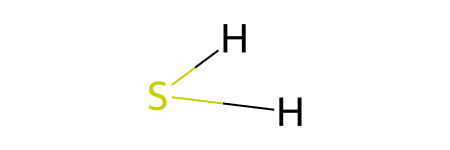

In [71]:
mol = feat_data[0][0].mol
mol

In [72]:
atom_extra_feats[atom_extra_feats['rxn_id'] == 'rmg_rxn_86']

,rxn_id,mol_type,focus_atom_idx,path,radius,angle,dihedral,r_exist,a_exist,d_exist,...,radius_rbf_9,radius_rbf_10,radius_rbf_11,radius_rbf_12,radius_rbf_13,radius_rbf_14,radius_rbf_15,dihedral_sin,dihedral_cos,angle_norm
0,rmg_rxn_86,r1h,0,"[1, 0]",0.800045,NaN,NaN,1,0,0,...,6.687422e-36,3.749810e-44,2.845581e-53,2.922427e-63,4.061882e-74,7.640505e-86,1.945037e-98,NaN,NaN,NaN
1,rmg_rxn_86,r1h,1,[1],NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rmg_rxn_86,r1h,2,"[1, 0, 2]",1.555851,1.564274,NaN,1,1,0,...,6.156103e-23,1.391282e-29,4.255352e-37,1.761436e-45,9.867549e-55,7.481053e-65,7.675863e-76,NaN,NaN,0.375913
3,rmg_rxn_86,r2h,0,[0],NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,rmg_rxn_86,r2h,1,"[0, 1]",0.800015,NaN,NaN,1,0,0,...,6.678763e-36,3.744416e-44,2.841078e-53,2.917382e-63,4.054287e-74,7.625121e-86,1.940841e-98,NaN,NaN,NaN
5,rmg_rxn_86,r2h,2,"[0, 1, 2]",1.775176,1.878623,NaN,1,1,0,...,9.905361e-20,6.543853e-26,5.850699e-33,7.079344e-41,1.159283e-49,2.569193e-59,7.705753e-70,NaN,NaN,0.500297
6,rmg_rxn_86,r2h,3,"[0, 1, 2, 3]",2.696499,1.871184,1.652788,1,1,1,...,5.451453e-09,3.261361e-13,2.640563e-18,2.893379e-24,4.290669e-31,8.611044e-39,2.338824e-47,0.028843,0.999584,0.497353
7,rmg_rxn_86,r2h,4,"[0, 1, 2, 3, 4]",2.697867,1.488569,1.328219,1,1,1,...,5.612798e-09,3.380423e-13,2.755331e-18,3.039398e-24,4.537456e-31,9.167444e-39,2.506658e-47,0.023180,0.999731,0.345957
8,rmg_rxn_86,r2h,5,"[0, 1, 6, 5]",2.492482,1.569666,-1.112450,1,1,1,...,5.472319e-11,1.207031e-15,3.603102e-21,1.455612e-27,7.958401e-35,5.888667e-43,5.896839e-52,-0.019415,0.999812,0.378046
9,rmg_rxn_86,r2h,6,"[0, 1, 6]",1.752324,1.851449,NaN,1,1,0,...,4.714465e-20,2.785207e-26,2.226863e-33,2.409576e-41,3.528569e-50,6.993069e-60,1.875634e-70,NaN,NaN,0.489544


In [73]:
if mol is not None:
    conf = mol.GetConformer()  # Gets the first conformer (3D coordinates)
    print(f"{'Idx':<4} {'Symbol':<3} {'X':>10} {'Y':>10} {'Z':>10}")
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        symbol = atom.GetSymbol()
        pos = conf.GetAtomPosition(idx)
        print(f"{idx:<4} {symbol:<3} {pos.x:10.4f} {pos.y:10.4f} {pos.z:10.4f}")
else:
    print("Failed to load molecule.")

Idx  Symbol          X          Y          Z
0    S      -0.0574    -0.0191     0.0033
1    H       0.4741     0.3755     0.4526
2    H       0.8593    -0.1312    -0.9671


In [74]:
train_data[0][0][0].y

[-4.0]

In [75]:
def get_atom_feats_for_dp(dp_name, atom_extra_feats):
    rxn_id, mol_type = dp_name.rsplit('_', 1)
    subset = atom_extra_feats[
        (atom_extra_feats['rxn_id'] == rxn_id) &
        (atom_extra_feats['mol_type'] == mol_type)
    ]
    # Sort by focus_atom_idx
    subset = subset.sort_values("focus_atom_idx")
    return subset


def attach_morgan_to_dps(dps):
    new_dps = []
    drop_cols = ['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle', 'dihedral','focus_atom_symbol']
    for dp in dps:
        # pick the mol you actually want to fingerprint:
        mol = dp.mol if not isinstance(dp.mol, tuple) else dp.mol[0]
        extra_atom_feats = get_atom_feats_for_dp(dp.name, atom_extra_feats).drop(columns=drop_cols).values
        new_dp = data.MoleculeDatapoint(
            mol=dp.mol,
            y=dp.y,
            weight=dp.weight,
            gt_mask=dp.gt_mask,
            lt_mask=dp.lt_mask,
            V_f=extra_atom_feats,
            E_f=dp.E_f,
            V_d=dp.V_d,
            x_d=dp.x_d,      # <-- lowercase x_d
            x_phase=dp.x_phase,
            name=dp.name
        )
        new_dps.append(new_dp)
    return new_dps


featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(extra_atom_fdim=22)

train_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(train_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]

val_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(val_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]
test_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(test_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]


In [76]:
train_datasets[1][0][0]

MolGraph(V=array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.50029651],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.01581087,
         0.999875  ,  0.19734158],
       [ 1.        ,  0.        ,  0.        , ..., -0.00913408,
         0.99995828,  0.25403   ],
       [ 1.        ,  0.        ,  0.        , ..., -0.02775143,
         0.99961485,  0.48230151]]), E=array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 

In [77]:
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler = train_mcdset.normalize_targets()

val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
test_mcdset = data.MulticomponentDataset(test_datasets)



In [78]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
featurizer.atom_fdim

94

In [79]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing(depth=4, dropout=0.2, d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim, d_h=512,
                                  ) for _ in range(len(MOL_TYPES))],
    n_components=len(MOL_TYPES), shared = False    
)

agg = nn.MeanAggregation()
ffn = nn.RegressionFFN(
    input_dim=mcmp.output_dim,
    output_transform=output_transform,
    dropout=0.2,
)
metric_list = [metrics.RMSE(), metrics.MAE(), metrics.R2Score()] # Only the first metric is used for training and early stopping
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
)

mcmpnn



MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=108, out_features=512, bias=False)
        (W_h): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=606, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList

In [80]:


# Trainer setup
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_callback = ModelCheckpoint(
    monitor="val/rmse",
    mode="min",
    save_top_k=1,
    filename="best_model",
)
early_stopping_callback = EarlyStopping(
    monitor="val/rmse",
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode="min",
)


# CSV logger setup
from lightning.pytorch.loggers import CSVLogger
csv_logger = CSVLogger(
    save_dir="logs",
    name="mcmpnn_experiment",
    version="v1"
)

trainer = pl.Trainer(
    logger=csv_logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    callbacks=[checkpoint_callback, early_stopping_callback],
    devices=1,
    max_epochs=200, # number of epochs to train for
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [81]:
trainer.fit(mcmpnn, train_loader, val_loader)

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mcmpnn_experiment/v1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/mcmpnn_experiment/v1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [82]:
trainer.test(mcmpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     4.96406888961792      │
│          test/r2          │    0.9460756778717041     │
│         test/rmse         │     7.352927207946777     │
└───────────────────────────┴───────────────────────────┘

[{'test/rmse': 7.352927207946777,
  'test/mae': 4.96406888961792,
  'test/r2': 0.9460756778717041}]

In [83]:
pred = trainer.predict(mcmpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [84]:
import torch
pred_t = torch.cat(pred)
pred_np = pred_t.detach().cpu().numpy()
target_y = []
for batch in test_loader:
    target_y.append(batch.Y)
target_y = torch.cat(target_y)
target_y_np = target_y.detach().cpu().numpy()

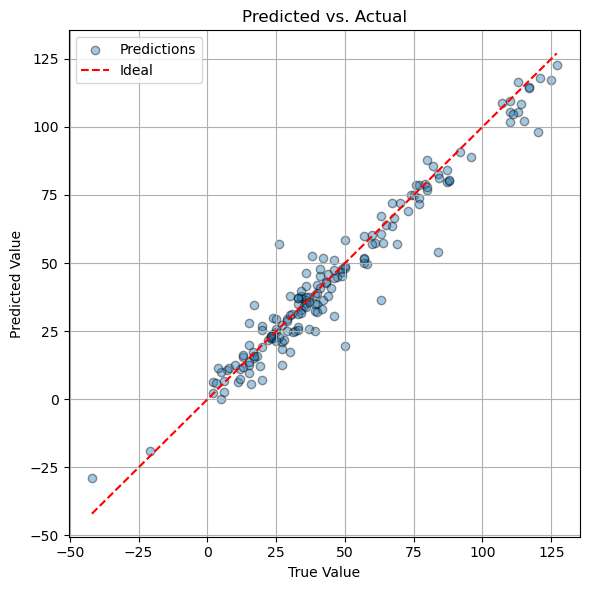

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: flatten if you have shape issues
target_y = np.array(target_y).flatten()
pred_np = np.array(pred_np).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(target_y, pred_np, alpha=0.4, edgecolor='k', label='Predictions')

# Plot y = x line (perfect prediction)
min_val = min(np.min(target_y), np.min(pred_np))
max_val = max(np.max(target_y), np.max(pred_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
target_y_np = target_y_np.flatten()
pred_np = pred_np.flatten()

mask = ~np.isnan(target_y_np) & ~np.isnan(pred_np)

target_y_clean = target_y_np[mask]
pred_clean = pred_np[mask]


In [87]:
target_y_clean.shape, pred_clean.shape

((170,), (170,))

In [88]:
target_y_np.shape, pred_np.shape

((170,), (170,))

In [89]:
#Get the stats of target_y_clean
print(f"Mean: {np.mean(target_y_clean):.4f}, Std: {np.std(target_y_clean):.4f}, Min: {np.min(target_y_clean):.4f}, Max: {np.max(target_y_clean):.4f}")

Mean: 45.8539, Std: 31.6642, Min: -42.0000, Max: 127.0000


# Reverse

In [90]:
target_data_pd = pd.read_csv(target_data)
target_data_pd[target_data_pd['direction'] == 'reverse'].describe()


,E0_total,E0_TS0,delta_E0
count,2.146000e+03,2.037000e+03,2037.000000
mean,-1.237917e+06,-1.259492e+06,63.623117
std,8.639917e+05,8.767670e+05,39.947772
min,-2.160071e+07,-2.160060e+07,-82.000000
25%,-1.565730e+06,-1.615020e+06,39.000000
50%,-1.096050e+06,-1.113430e+06,61.000000
75%,-8.087272e+05,-8.168030e+05,83.000000
max,-1.062690e+05,-1.075370e+05,364.000000


In [91]:
feat_data = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), filter_rules={'direction': 'reverse'},
                       path = target_data, set_col_index=False, target_col=['delta_E0'], reverse_mol_types=True,
                       include_extra_features = False)

Using reverse mol types...
['r2h', 'r1h']
Reaction ID kfir_rxn_13503 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_501 due to NaN in targets: [nan]
Skipping rmg_rxn_55 due to NaN in targets: [nan]
Skipping rmg_rxn_504 due to NaN in targets: [nan]
Skipping rmg_rxn_151 due to NaN in targets: [nan]
Skipping rmg_rxn_28 due to NaN in targets: [nan]
Skipping rmg_rxn_506 due to NaN in targets: [nan]
Skipping rmg_rxn_396 due to NaN in targets: [nan]
Skipping rmg_rxn_642 due to NaN in targets: [nan]
Skipping rmg_rxn_1496 due to NaN in targets: [nan]
Skipping rmg_rxn_507 due to NaN in targets: [nan]
Skipping rmg_rxn_15591 due to NaN in targets: [nan]
Skipping rmg_rxn_511 due to NaN in targets: [nan]
Skipping rmg_rxn_499 due to NaN in targets: [nan]
Skipping rmg_rxn_383 due to NaN in targets: [nan]
Skipping rmg_rxn_227 due to NaN in targets: [nan]
Skipping rmg_rxn_1532 due to NaN in targets: [nan]
Reaction ID kfir_rxn_13897 not found in target data. Skipping this SDF file.
Sk

In [92]:
feat_data[0]

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7198fd0592a0>, y=[11.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_86_r2h', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7198fd05b0d0>, y=[63.15999999997439], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rxn_191_r2h', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7198fd05bb50>, y=[62.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rxn_618_r2h', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7198fd059690>, y=[83.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rxn_1833_r2h', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7198fd0589e0>, y=[45.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_182_r2h', V_f=None, E_f=None, 

In [93]:
component_to_split_by = 0
mols = [d.mol for d in feat_data[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "kennard_stone", (0.8, 0.1, 0.1))


train_data, val_data, test_data = data.split_data_by_indices(
    feat_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [94]:
import numpy as np
import pandas as pd

# Your DataFrame and rxn_ids
# atom_extra_feats: DataFrame with all data
# rxn_ids: list of rxn_ids in the train set

# 1. Subset for fitting
train_mask = atom_extra_feats['rxn_id'].isin(rxn_ids)
train_feats = atom_extra_feats[train_mask]

# 2. Compute parameters from training data
num_centers = 16
r_min = train_feats['radius'].min()
r_max = train_feats['radius'].max()
a_min = train_feats['angle'].min()
a_max = train_feats['angle'].max()

# 3. Apply to all data using train params
radius_rbf = rbf_expand(atom_extra_feats['radius'].values, num_centers=num_centers, r_min=r_min, r_max=r_max)
dihedral_sc = dihedral_to_sin_cos(atom_extra_feats['dihedral'].values)
angle_norm = normalize_angle(atom_extra_feats['angle'].values, a_min=a_min, a_max=a_max)

# 4. Stack or add to DataFrame
for i in range(num_centers):
    atom_extra_feats[f'radius_rbf_{i}'] = radius_rbf[:, i]
atom_extra_feats['dihedral_sin'] = dihedral_sc[:, 0]
atom_extra_feats['dihedral_cos'] = dihedral_sc[:, 1]
atom_extra_feats['angle_norm'] = angle_norm


In [95]:
rbf_params = dict(num_centers=num_centers, r_min=r_min, r_max=r_max)
angle_norm_params = dict(a_min=a_min, a_max=a_max)

print(rbf_params)
print(angle_norm_params)

{'num_centers': 16, 'r_min': 0.7998821538201737, 'r_max': 6.933882468718373}
{'a_min': 0.6142472914325002, 'a_max': 3.141500920022701}


In [96]:
MOL_TYPES = ['r2h', 'r1h']

def get_atom_feats_for_dp(dp_name, atom_extra_feats):
    rxn_id, mol_type = dp_name.rsplit('_', 1)
    subset = atom_extra_feats[
        (atom_extra_feats['rxn_id'] == rxn_id) &
        (atom_extra_feats['mol_type'] == mol_type)
    ]
    # Sort by focus_atom_idx
    subset = subset.sort_values("focus_atom_idx")
    return subset


def attach_morgan_to_dps(dps):
    new_dps = []
    drop_cols = ['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle', 'dihedral','focus_atom_symbol']
    for dp in dps:
        # pick the mol you actually want to fingerprint:
        mol = dp.mol if not isinstance(dp.mol, tuple) else dp.mol[0]
        extra_atom_feats = get_atom_feats_for_dp(dp.name, atom_extra_feats).drop(columns=drop_cols).values
        new_dp = data.MoleculeDatapoint(
            mol=dp.mol,
            y=dp.y,
            weight=dp.weight,
            gt_mask=dp.gt_mask,
            lt_mask=dp.lt_mask,
            V_f=extra_atom_feats,
            E_f=dp.E_f,
            V_d=dp.V_d,
            x_d=dp.x_d,      # <-- lowercase x_d
            x_phase=dp.x_phase,
            name=dp.name
        )
        new_dps.append(new_dp)
    return new_dps


featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(extra_atom_fdim=22)

train_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(train_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]

val_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(val_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]
test_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(test_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]


In [97]:
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler = train_mcdset.normalize_targets()

val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
test_mcdset = data.MulticomponentDataset(test_datasets)



In [98]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)

In [99]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

In [100]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing(depth=4, dropout=0.3, d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim, d_h=1024,
                                  ) for _ in range(len(MOL_TYPES))],
    n_components=len(MOL_TYPES), shared = False    
)

agg = nn.MeanAggregation()
ffn = nn.RegressionFFN(
    input_dim=mcmp.output_dim,
    output_transform=output_transform,
    dropout=0.3,
)
metric_list = [metrics.RMSE(), metrics.MAE(), metrics.R2Score()] # Only the first metric is used for training and early stopping
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
)

mcmpnn



MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=108, out_features=1024, bias=False)
        (W_h): Linear(in_features=1024, out_features=1024, bias=False)
        (W_o): Linear(in_features=1118, out_features=1024, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.3, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): Modul

In [101]:


# Trainer setup
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_callback = ModelCheckpoint(
    monitor="val/rmse",
    mode="min",
    save_top_k=1,
    filename="best_model",
)
early_stopping_callback = EarlyStopping(
    monitor="val/rmse",
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode="min",
)


# CSV logger setup
from lightning.pytorch.loggers import CSVLogger
csv_logger = CSVLogger(
    save_dir="logs",
    name="mcmpnn_experiment",
    version="v1"
)

trainer = pl.Trainer(
    logger=csv_logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    callbacks=[checkpoint_callback, early_stopping_callback],
    devices=1,
    max_epochs=200, # number of epochs to train for
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [102]:
trainer.fit(mcmpnn, train_loader, val_loader)

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mcmpnn_experiment/v1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/mcmpnn_experiment/v1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [103]:
trainer.test(mcmpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     9.21849536895752      │
│          test/r2          │    0.8006536364555359     │
│         test/rmse         │    14.722935676574707     │
└───────────────────────────┴───────────────────────────┘

[{'test/rmse': 14.722935676574707,
  'test/mae': 9.21849536895752,
  'test/r2': 0.8006536364555359}]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

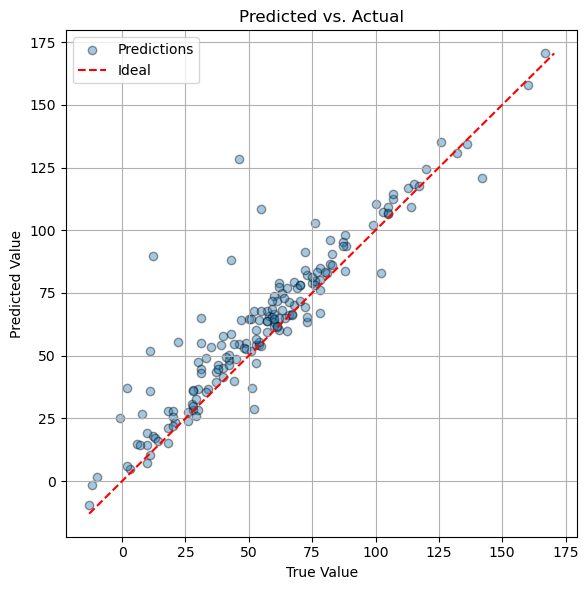

In [104]:
pred = trainer.predict(mcmpnn, test_loader)
import torch
pred_t = torch.cat(pred)
pred_np = pred_t.detach().cpu().numpy()
target_y = []
for batch in test_loader:
    target_y.append(batch.Y)
target_y = torch.cat(target_y)
target_y_np = target_y.detach().cpu().numpy()
import matplotlib.pyplot as plt
import numpy as np

# Optional: flatten if you have shape issues
target_y = np.array(target_y).flatten()
pred_np = np.array(pred_np).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(target_y, pred_np, alpha=0.4, edgecolor='k', label='Predictions')

# Plot y = x line (perfect prediction)
min_val = min(np.min(target_y), np.min(pred_np))
max_val = max(np.max(target_y), np.max(pred_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Combined

In [105]:
data_fwd = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), filter_rules={'direction': 'forward'},
                       path = target_data, set_col_index=False, target_col=['delta_E0'], reverse_mol_types=False,
                       include_extra_features = False)
# reversed order
data_rev = feat_data = Featuriser(os.path.expanduser("~/code/chemprop_phd_customised/habnet/data/processed/sdf_data"), filter_rules={'direction': 'reverse'},
                       path = target_data, set_col_index=False, target_col=['delta_E0'], reverse_mol_types=True,
                       include_extra_features = False)

# now merge: for each component index i, extend
combined = []
for comp_idx in range(len(MOL_TYPES)):
    combined.append(data_fwd[comp_idx] + data_rev[comp_idx])

Reaction ID kfir_rxn_13503 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_501 due to NaN in targets: [nan]
Skipping rmg_rxn_55 due to NaN in targets: [nan]
Skipping rmg_rxn_504 due to NaN in targets: [nan]
Skipping rmg_rxn_151 due to NaN in targets: [nan]
Skipping rmg_rxn_28 due to NaN in targets: [nan]
Reaction ID rmg_rxn_506 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_396 due to NaN in targets: [nan]
Skipping rmg_rxn_642 due to NaN in targets: [nan]
Skipping rmg_rxn_1496 due to NaN in targets: [nan]
Skipping rmg_rxn_507 due to NaN in targets: [nan]
Skipping rmg_rxn_15591 due to NaN in targets: [nan]
Skipping rmg_rxn_511 due to NaN in targets: [nan]
Skipping rmg_rxn_499 due to NaN in targets: [nan]
Skipping rmg_rxn_383 due to NaN in targets: [nan]
Skipping rmg_rxn_227 due to NaN in targets: [nan]
Skipping rmg_rxn_1532 due to NaN in targets: [nan]
Reaction ID kfir_rxn_13897 not found in target data. Skipping this SDF file.
Skipping rmg_rxn_153

In [106]:
len(combined[0])

3388

In [107]:
combined[0][0]

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x719c545c0890>, y=[-4.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_86_r1h', V_f=None, E_f=None, V_d=None)

In [108]:
combined[1][0]

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x719c545c1690>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rmg_rxn_86_r2h', V_f=None, E_f=None, V_d=None)

In [109]:
combined[0][-1]

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x719c456b47b0>, y=[2.0], weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rxn_53_r2h', V_f=None, E_f=None, V_d=None)

In [110]:
combined[1][-1]

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x719c456b4820>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='rxn_53_r1h', V_f=None, E_f=None, V_d=None)

In [111]:
component_to_split_by = 0
mols = [d.mol for d in combined[component_to_split_by]]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "kennard_stone", (0.8, 0.1, 0.1))


train_data, val_data, test_data = data.split_data_by_indices(
    combined, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [112]:
len(train_data[0][0]), len(val_data[0][0]), len(test_data[0][0])

(2710, 338, 340)

In [113]:
rxn_ids = []
for i in range(len(train_data[0][0])):
    rxn_name = train_data[0][0][i].name
    # Need to remove _r1h or _r2h from the reaction name
    rxn_name = rxn_name.replace('_r1h', '').replace('_r2h', '')
    rxn_ids.append(rxn_name)

In [114]:
# Read extra info
atom_extra_feats = pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/preprocessing/all_sdf_features.csv")
atom_extra_feats.columns

Index(['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle',
       'dihedral', 'r_exist', 'a_exist', 'd_exist', 'focus_atom_symbol'],
      dtype='object')

In [115]:
import numpy as np
import pandas as pd

# Your DataFrame and rxn_ids
# atom_extra_feats: DataFrame with all data
# rxn_ids: list of rxn_ids in the train set

# 1. Subset for fitting
train_mask = atom_extra_feats['rxn_id'].isin(rxn_ids)
train_feats = atom_extra_feats[train_mask]

# 2. Compute parameters from training data
num_centers = 16
r_min = train_feats['radius'].min()
r_max = train_feats['radius'].max()
a_min = train_feats['angle'].min()
a_max = train_feats['angle'].max()

# 3. Apply to all data using train params
radius_rbf = rbf_expand(atom_extra_feats['radius'].values, num_centers=num_centers, r_min=r_min, r_max=r_max)
dihedral_sc = dihedral_to_sin_cos(atom_extra_feats['dihedral'].values)
angle_norm = normalize_angle(atom_extra_feats['angle'].values, a_min=a_min, a_max=a_max)

# 4. Stack or add to DataFrame
for i in range(num_centers):
    atom_extra_feats[f'radius_rbf_{i}'] = radius_rbf[:, i]
atom_extra_feats['dihedral_sin'] = dihedral_sc[:, 0]
atom_extra_feats['dihedral_cos'] = dihedral_sc[:, 1]
atom_extra_feats['angle_norm'] = angle_norm


In [116]:
rbf_params = dict(num_centers=num_centers, r_min=r_min, r_max=r_max)
angle_norm_params = dict(a_min=a_min, a_max=a_max)

print(rbf_params)
print(angle_norm_params)

{'num_centers': 16, 'r_min': 0.7998821538201737, 'r_max': 6.933882468718373}
{'a_min': 0.6142472914325002, 'a_max': 3.141500920022701}


In [117]:
MOL_TYPES = ['r2h', 'r1h']

def get_atom_feats_for_dp(dp_name, atom_extra_feats):
    rxn_id, mol_type = dp_name.rsplit('_', 1)
    subset = atom_extra_feats[
        (atom_extra_feats['rxn_id'] == rxn_id) &
        (atom_extra_feats['mol_type'] == mol_type)
    ]
    # Sort by focus_atom_idx
    subset = subset.sort_values("focus_atom_idx")
    return subset


def attach_morgan_to_dps(dps):
    new_dps = []
    drop_cols = ['rxn_id', 'mol_type', 'focus_atom_idx', 'path', 'radius', 'angle', 'dihedral','focus_atom_symbol']
    for dp in dps:
        # pick the mol you actually want to fingerprint:
        mol = dp.mol if not isinstance(dp.mol, tuple) else dp.mol[0]
        extra_atom_feats = get_atom_feats_for_dp(dp.name, atom_extra_feats).drop(columns=drop_cols).values
        new_dp = data.MoleculeDatapoint(
            mol=dp.mol,
            y=dp.y,
            weight=dp.weight,
            gt_mask=dp.gt_mask,
            lt_mask=dp.lt_mask,
            V_f=extra_atom_feats,
            E_f=dp.E_f,
            V_d=dp.V_d,
            x_d=dp.x_d,      # <-- lowercase x_d
            x_phase=dp.x_phase,
            name=dp.name
        )
        new_dps.append(new_dp)
    return new_dps


featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(extra_atom_fdim=22)

train_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(train_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]

val_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(val_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]
test_datasets = [
    data.MoleculeDataset(
        attach_morgan_to_dps(test_data[0][i]),
        featurizer
    )
    for i in range(len(MOL_TYPES))
]


In [118]:
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler = train_mcdset.normalize_targets()

val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
test_mcdset = data.MulticomponentDataset(test_datasets)

In [119]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
featurizer.atom_fdim

94

In [120]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing(depth=4, dropout=0.3, d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim, d_h=1024,
                                  ) for _ in range(len(MOL_TYPES))],
    n_components=len(MOL_TYPES), shared = False    
)

agg = nn.MeanAggregation()
ffn = nn.RegressionFFN(
    input_dim=mcmp.output_dim,
    output_transform=output_transform,
    dropout=0.3,
)
metric_list = [metrics.RMSE(), metrics.MAE(), metrics.R2Score()] # Only the first metric is used for training and early stopping
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
)

mcmpnn



MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=108, out_features=1024, bias=False)
        (W_h): Linear(in_features=1024, out_features=1024, bias=False)
        (W_o): Linear(in_features=1118, out_features=1024, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.3, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): Modul

In [121]:


# Trainer setup
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_callback = ModelCheckpoint(
    monitor="val/rmse",
    mode="min",
    save_top_k=1,
    filename="best_model",
)
early_stopping_callback = EarlyStopping(
    monitor="val/rmse",
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode="min",
)


# CSV logger setup
from lightning.pytorch.loggers import CSVLogger
csv_logger = CSVLogger(
    save_dir="logs",
    name="mcmpnn_experiment",
    version="v1"
)

trainer = pl.Trainer(
    logger=csv_logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    callbacks=[checkpoint_callback, early_stopping_callback],
    devices=1,
    max_epochs=200, # number of epochs to train for
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [122]:
trainer.fit(mcmpnn, train_loader, val_loader)

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mcmpnn_experiment/v1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/mcmpnn_experiment/v1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name            | Type                         | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [123]:
trainer.test(mcmpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/habnet_rocm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     5.974956035614014     │
│          test/r2          │    0.9062747955322266     │
│         test/rmse         │    10.455361366271973     │
└───────────────────────────┴───────────────────────────┘

[{'test/rmse': 10.455361366271973,
  'test/mae': 5.974956035614014,
  'test/r2': 0.9062747955322266}]